# Deep Learning Project (DD2424)


## -- INITIAL SETUP --

### 0.1 Download datasets

In [ ]:
download_data = True

In [ ]:
if download_data:
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

    !mkdir oxford-iiit-pet/
    !tar -xf images.tar.gz -C oxford-iiit-pet/
    !tar -xf annotations.tar.gz -C oxford-iiit-pet/
    !rm images.tar.gz
    !rm annotations.tar.gz

else:
    print("Note: Assuming that data is manually downloaded!")
    # --> Alternative is to manually download datasets here: https://www.robots.ox.ac.uk/~vgg/data/pets/
    #  Note: must have the folder "oxford-iiit-pet" in same directory as code/notebook

### 0.2 Define Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision

from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.ops.boxes import masks_to_boxes

from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import transforms

### 0.3 Example plot

In [ ]:
from torchvision.io import read_image

# -- PLOT EXAMPLE IMAGE AND MASK --
name = 'samoyed_189'
img = read_image(f'oxford-iiit-pet/images/{name}.jpg')
mask = read_image(f'oxford-iiit-pet/annotations/trimaps/{name}.png')

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.subplot(122)
plt.imshow(mask.permute(1, 2, 0))
plt.axis('off')
plt.show()

## -- DATA PREPROCESSING --


### 1.1 Define datasets and dataloaders and subset splits (train, validation, test):

In [ ]:
# --------- Transform pipeline ---------

def transform_pipeline(in_data):
    # Define an ordered collection of functions/transformations to apply to all images
    pipeline = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)

def load_dataset(target_type="binary-category", ):
    ttransform = target_transform if target_type=="category" else None
    # Load in all the data within file 'trainval.txt'
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline, target_transform=ttransform, target_types=[target_type] )
    #return dataset

def target_transform(target):

    hot = torch.zeros((37))

    hot[target-1] = 1
    #cat_classes = {6, 34, 12, 27, 33, 7, 24, 21, 10, 28, 1, 8}  # set lookup is faster
    #return 0 if target in cat_classes else 1

    return hot   # if we use ["binary-category"]

def create_split_idxs(n_tot, f_train=0.8, f_valid=0.1, f_test=0.1):

    if f_train + f_valid + f_test > 1:
        print("ERROR: FACTORS TOO LARGE TO CREATE SPLITS, TRY AGAIN")

    # Range from index 0 to n==len(dataset)
    idxes = np.arange(n_tot)
    np.random.seed(42)   # random seed to ensure repeatability
    np.random.shuffle(idxes)

    # split limits:
    s1 = int(n_tot*f_train)
    s2 = int(n_tot*(f_train+f_valid))

    # Create index lists
    train_idx = idxes[:s1]
    val_idx = idxes[s1:s2]
    test_idx = idxes[s2:]

    return train_idx, val_idx, test_idx


def get_dataloaders(n_batch, f_train=0.8, f_valid=0.1, f_test=0.1, target_type="binary-category"):
    # Load in all data
    dataset = load_dataset(target_type=target_type)

    # Test it
    image, label = dataset[0]
    print(f"Image shape: {image.shape}")

    # Create shuffled index splitting for each subset
    train_idx, val_idx, test_idx = create_split_idxs(len(dataset), f_train, f_valid, f_test)

    # Split using imported Subset class
    dataset_train = Subset(dataset, train_idx)
    dataset_test = Subset(dataset, test_idx)
    dataset_val = Subset(dataset, val_idx)

    # Create data loader containing datasets
    dataloader_train = DataLoader(dataset_train, batch_size=n_batch, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=n_batch, shuffle=False, num_workers=2)
    dataloader_val = DataLoader(dataset_val, batch_size=n_batch, shuffle=True, num_workers=2)

    return dataloader_train, dataloader_test, dataloader_val


### 1.2 Plot random example images to show pre-processing (scaling and cropping)

In [ ]:
dataset = load_dataset("category")

#print(len(dataset[0]))

# plot example image
plt.figure(figsize=(10, 10))
plt.subplot(121)

dog = 2600
plt.imshow(dataset[dog][0].permute(1, 2, 0))
plt.axis('off')
plt.title(f"label={dataset[dog][1]}")
plt.subplot(122)

cat = 300
plt.imshow(dataset[cat][0].permute(1, 2, 0))
plt.title(f"label={dataset[cat][1]}")

plt.axis('off')

plt.show()


### (maybe todo) 1.3 Define zero-mean normalization across all data

In [ ]:
def zero_mean(dataloader):
    # TODO: FIXME IF WE WANT TO DO ZERO MEAN NORMALIZATION

    #print(next(iter(dataloader_test))[0].shape)  # torch.Size([64, 3, 224, 224])
    #img = next(iter(dataloader_test))[0][0]
    #print(img.max())
    #print(img.min())
    #print(max(next(iter(dataloader_test))))

    img, _ = next(iter(dataloader))
    img = img[0]
    print(f'max: {torch.max(img)}')
    print(f'min: {torch.min(img)}')
    print(f'mean: {torch.mean(img)}')


## -- NETWORK SETUP --

### 2.0 Network Imports

In [ ]:
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchvision.models import resnet50
from torchvision.models import resnet101
from torchvision.models import wide_resnet50_2
#from torchvision.models import resnet152

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


### 2.1 Define model and training functions

In [ ]:
def create_model_and_optim_binary(choice="resnet34", lr=0.001, wd=0.0005):

    # Load in pretrained model of our choice:
    if choice == "resnet18":
        model = resnet18(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet34":
        model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet50":
        model = resnet50(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet101":
        model = resnet101(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    else:
        print("model choice does not match")
        exit()

    # As instructed, only replace final layer with same in but one out (cat/dog)
    in_features = model.fc.in_features   # size of input of final layer --> 512
    #print(model.fc.out_features)   # size of output into final layer --> 1000

    # Create a new Linear layer to replace last fc layer with:
    model.fc = torch.nn.Linear(in_features, 1)  # for binary classification instead of outputting 1000

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True   # update these layer weights (only last)

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=wd)
    # TODO: maybe look into NAG as alternative

    return model, optimizer


def train_binary(model, dataloader, optimizer, epochs=1):
    losses = []

    model = model.to(device)

    model.train()  # tells model we will train now maybe
    criterion = torch.nn.BCEWithLogitsLoss()
    # trains in batches
    for e in range(epochs):

        running_loss = 0.0

        # for each batch:
        for i, (img, binary_category) in enumerate(dataloader):

            #print(img.shape)  # torch.Size([64, 3, 224, 224])

            img = img.to("cuda")
            binary_category = binary_category.to("cuda")

            # Forward pass of network
            output = model(img)

            # Compute loss
            # TODO: check if we want to use another loss function
            loss = criterion(output, binary_category.view(-1, 1).float())

            # Compute gradients
            loss.backward()

            # Backprop
            optimizer.step()  # update weights with grads

            batch_loss = loss.item()

            losses.append(batch_loss)
            running_loss += batch_loss

            print(f"\r Epoch {e+1}/{epochs} : Batch {i+1}/{len(dataloader)} : Loss {batch_loss}", end="")

            optimizer.zero_grad()  # reset grads

    return losses


## -- NETWORK TRAINING --

### 2.3 Initialize data

In [ ]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="binary-category")

print("done loading data")
print("number of batches:", len(dataloader_train))



### 2.3 Initialize model

In [ ]:
print(f"cuda == {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_binary, optimizer_binary = create_model_and_optim_binary(choice="resnet34", lr=0.001, wd=0.0005)


### 2.4 Train binary network

In [ ]:
#print(torch.cuda.get_device_name(0))  # Tesla P4

print("Start training")
losses = train_binary(model_binary, dataloader_train, optimizer_binary, epochs=1)


### 2.5 Plot losses and compute accuracy

In [ ]:
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_losses(losses):
    #losses_cpu = [loss.cpu().detach().numpy() for loss in losses]
    losses_cpu = [loss for loss in losses]
    #plt.plot(smooth(losses_cpu))
    plt.plot(losses_cpu)
    plt.xlabel("batch nr")
    plt.ylabel("training loss")


In [ ]:
# Plot
plot_losses(losses)


### 2.6 Binary Accuracy

In [ ]:
# TODO: FIXME
def compute_accuracy_binary(model, dataloader_test):
    total = 0
    correct = 0

    # no grad so it's faster (--> Julia edit: 'no_grad()' ensures that we can calculate with tensors without affecting it's gradients in backprop)
    with torch.no_grad():

        model.eval()

        for i, (img, binary_category) in enumerate(dataloader_test):
            img = img.to("cuda")
            binary_category = binary_category.to("cuda").view(-1, 1).float()   # torch.Size([32, 1])

            output = model(img)                                     # torch.Size([32, 1])
            prediction = torch.round(torch.sigmoid(output))         # torch.Size([32, 1])

            total += binary_category.size(0)
            correct += (prediction == binary_category).sum().item()

            print(f'\r({i+1}/{len(dataloader_test)}) accuracy: {100 * correct / total} %', end="")
        print(f'\nTest accuracy: {100 * correct / total} %')


def compute_confusion_matrix():
    pass

In [ ]:
# NOTE/WARNING:
compute_accuracy_binary(model_binary, dataloader_test)

## -- MULTICLASS --

### 3.1 Modify network for multiclass classification

In [ ]:
def create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=1, separate_scheduler=False):

    # Load in pretrained model of our choice:
    if choice == "resnet18":
        model = resnet18(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet34":
        model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet50":
        model = resnet50(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet101":
        model = resnet101(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    else:
        print("model choice does not match")
        exit()

    # Create a new Linear layer to replace last fc layer with:
    model.fc = torch.nn.Linear(model.fc.in_features, 37)  # for binary classification instead of outputting 1000

    modules = [model.fc, model.layer4, model.layer3, model.layer2, model.layer1]
    layers_to_unfreeze = modules[:n_freeze]

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the ones we want
    for layer in layers_to_unfreeze:
        #print("freeeeze")
        for param in layer.parameters():
            param.requires_grad = True

    optimizers = []
    schedulers = []

    if separate_scheduler:
        for i, layer in enumerate(layers_to_unfreeze):
            optimizers.append(torch.optim.Adam(
                filter(lambda p: p.requires_grad, layer.parameters()),
                lr=lr*0.1**i, # exponential decay of lr for each layer
                weight_decay=wd
            ))
            schedulers.append(torch.optim.lr_scheduler.StepLR(optimizers[i], step_size=3, gamma=0.1))
    else:
        optimizers.append(torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=lr,
            weight_decay=wd
        ))

        schedulers.append(torch.optim.lr_scheduler.StepLR(optimizers[0], step_size=3, gamma=0.1))

    return model, optimizers, schedulers

def train_multi(model, dataloader, optimizers, epochs=1, schedulers=[], weight=None):
    losses = []
    model = model.to(device)
    model.train()  # tells model we will train now maybe
    criterion = torch.nn.CrossEntropyLoss(weight=weight)

    # trains in batches
    for e in range(epochs):
        running_loss = 0.0
        # for each batch:
        for i, (img, category) in enumerate(dataloader):
            img = img.to("cuda")
            category = category.squeeze().float().to("cuda")
            output = model(img) # Forward pass of network

            loss = criterion(output, category) # TODO: check if we want to use another loss function
            loss.backward() # Compute gradients
            for optimizer in optimizers:
                optimizer.step()# Backprop # update weights with grads
            batch_loss = loss.item()
            losses.append(batch_loss)
            running_loss += batch_loss
            print(f"\r Epoch {e+1}/{epochs} : Batch {i+1}/{len(dataloader)} : Loss {batch_loss}", end="")
            optimizer.zero_grad()  # reset grads
        for scheduler in schedulers:
            scheduler.step()

    return losses

### 3.2 Load in multiclass data

In [ ]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="category")

print("done loading multiclass data")
print("number of batches:", len(dataloader_train))


### 3.3 Initialize model

In [ ]:
### 2.3 Initialize model, train, and plot losses
print(f"cuda == {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1, optimizers1, schedulers1 = create_model_and_optim_multi(choice="resnet50", lr=0.0005, wd=0.0005, n_freeze=3)
#model2, optimizer2, scheduler2 = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=2)
#model3, optimizer3, scheduler3 = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=3)


### 3.4 Train multiclass model

In [ ]:
print("Start training")
losses = train_multi(model1, dataloader_train, optimizers1, epochs=10, schedulers=schedulers1)
#losses2 = train_multi(model2, dataloader_train, optimizer2, epochs=1)
#losses3 = train_multi(model3, dataloader_train, optimizer3, epochs=1)

### 3.5 Multiclass metric calculations

In [ ]:
# TODO: FIXME
def compute_accuracy_multi(model, dataloader_test):
    total = 0
    correct = 0
    model = model.to(device)

    # no grad so it's faster (--> Julia edit: I think 'no_grad()' ensures that we can calculate with tensors without affecting its gradients in backprop)
    with torch.no_grad():
        model.eval()
        for i, (img, category) in enumerate(dataloader_test):
            img = img.to("cuda")
            category = torch.argmax(category, axis=1).to("cuda")  # torch.Size([32, 37]) ---> torch.Size([32])

            output = model(img)  # torch.Size([32, 37])
            # from output choose class/index with the highest value (probability?)
            prediction = torch.argmax(output, axis=1)   # torch.Size([32])

            total += category.size(0)
            correct += (prediction == category).sum().item()

    return correct / total


In [ ]:
def get_predictions(model, dataloader_test):
    model = model.to(device)
    predictions = np.zeros((len(dataloader_test.dataset)))

    # no grad so it's faster (--> Julia edit: I think 'no_grad()' ensures that we can calculate with tensors without affecting its gradients in backprop)
    with torch.no_grad():
        model.eval()
        for i, (img, category) in enumerate(dataloader_test):
            img = img.to("cuda")
            category = torch.argmax(category, axis=1).to("cuda")  # torch.Size([32, 37]) ---> torch.Size([32])

            output = model(img)  # torch.Size([32, 37])
            # from output choose class/index with the highest value (probability?)
            prediction = torch.argmax(output, axis=1)   # torch.Size([32])
            predictions[i*32:(i+1)*32] = prediction.cpu().numpy()

    return predictions

Calculate precision and recall, then F1 macro score.

$ precision = \frac{TP}{TP + FP} $

$ recall = \frac{TP}{TP + FN} $

$ F_1 = \frac{2}{recall^{-1} + precision^{-1}} = \frac{2TP}{2TP + FP + FN}$

Plot distribution of true classes and predicted classes:

In [ ]:
def compute_confusion_matrix(preds, y_test):
    TP = np.zeros((37))
    FP = np.zeros((37))
    TN = np.zeros((37))
    FN = np.zeros((37))

    for i in range(len(preds)):
        if preds[i] == y_test[i]:
            TP[int(preds[i])] += 1
        else:
            FP[int(preds[i])] += 1
            FN[int(y_test[i])] += 1
            TN[int(y_test[i])] += 1

    return TP, FP, TN, FN

# find f1 score for each class
def f1_score(TP, FP, TN, FN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1.mean()

In [ ]:
def bin_conf_matrix_from_class(TP, FP, TN, FN):
    TP_BIN = np.sum(TP[:12])
    FP_BIN = np.sum(FP[:12])
    TN_BIN = np.sum(TP[12:])
    FN_BIN = np.sum(FP[12:])
    return TP_BIN, FP_BIN, TN_BIN, FN_BIN

def f1_score_binary(model, dataloader_test):
    TP, FP, TN, FN = compute_confusion_matrix(get_predictions(model, dataloader_test), y_test)
    TP_BIN, FP_BIN, TN_BIN, FN_BIN = bin_conf_matrix_from_class(TP, FP, TN, FN)
    return f1_score(TP_BIN, FP_BIN, TN_BIN, FN_BIN)

## -- EXPERIMENTS --

#### 4.1 Strategy 1

In [ ]:
def train_multi_simul(num_layers, dataloader_train):
    print(f"\n=== Training with {num_layers} layers unfreezed ===")
    model, optimizers, schedulers = create_model_and_optim_multi(
            choice="resnet50",
            lr=0.0005, 
            wd=0.0005, 
            n_freeze=num_layers,
            separate_scheduler=True # lwering lr exponentially for each layer
        )
    losses = train_multi(model, dataloader_train, optimizers, epochs=5, schedulers=schedulers)
    
    return model

In [ ]:
num_layers_to_unfreeze = [1,2,3,4]
strategy1_models = []

for num_layers in num_layers_to_unfreeze:
    model = train_multi_simul(num_layers, dataloader_train)
    strategy1_models.append(model)

In [ ]:
for i in range(len(strategy1_models)):
    print(f"\n=== Evaluating model with {num_layers_to_unfreeze[i]} layers unfreezed ===")
    acc = compute_accuracy_multi(strategy1_models[i], dataloader_test)
    print(f"Test accuracy: {100 * acc:.2f}%")

    # save all models
    torch.save({
        'model_state_dict': strategy1_models[i].state_dict(),
        'accuracy': acc,
    }, f'strategy1_model_{num_layers_to_unfreeze[i]}_layers.pth')
    

#### 4.2 Strategy 2

In [ ]:
def train_multi_gradual(num_layers, dataloader_train):
    # Start with just the final layer
    model, optimizers, schedulers = create_model_and_optim_multi(
            choice="resnet50",
            lr=0.0005, 
            wd=0.0005, 
            n_freeze=1, 
            separate_scheduler=True
        )

    for stage in range(1, num_layers+1):  # Gradually unfreeze more layers
        print(f"Fine-tuning last {stage} layers")
        
        # Unfreeze additional layer
        if stage > 1:
            modules = [model.fc, model.layer4, model.layer3, model.layer2]
            layer_to_unfreeze = modules[stage-1]
            
            for param in layer_to_unfreeze.parameters():
                param.requires_grad = True
            
            # add optimizer for the new layer
            optimizers.append(torch.optim.Adam(
                layer_to_unfreeze.parameters(),
                lr=0.0005*0.1**(stage-1), # exponential decay of lr for each layer
                weight_decay=0.0005
            ))
            # add scheduler for the new layer
            schedulers.append(torch.optim.lr_scheduler.StepLR(optimizers[-1], step_size=3, gamma=0.1))
        
        # train for a few epochs
        train_multi(model, dataloader_train, optimizers, epochs=2, schedulers=schedulers)
    return model

In [ ]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="category")
strategy2_models = []

for num_layers in num_layers_to_unfreeze:
    print(f"\n=== Training with {num_layers} layers unfreezed ===")
    model = train_multi_gradual(num_layers, dataloader_train)
    strategy2_models.append(model)

In [ ]:
for i in range(len(strategy2_models)):
    print(f"\n=== Evaluating model with {num_layers_to_unfreeze[i]} layers unfreezed ===")
    acc = compute_accuracy_multi(strategy2_models[i], dataloader_test)
    print(f"Test accuracy: {100 * acc:.2f}%")

    # save all models
    torch.save({
        'model_state_dict': strategy2_models[i].state_dict(),
        'accuracy': acc,
    }, f'strategy2_model_{num_layers_to_unfreeze[i]}_layers.pth')
    

#### 4.3 Data augmentation

In [ ]:
# transform pipeline for data augmentation
def transform_pipeline_augmented(in_data):
    """Transform pipeline with data augmentation"""
    pipeline = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)

# create augmented dataset
def load_dataset_augmented(target_type="category"):
    ttransform = target_transform if target_type=="category" else None
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline_augmented,
                        target_transform=ttransform, target_types=[target_type])


Choose the best model of strategy 1 and 2 and train with data augmentation. 

In [ ]:
# Train with augmentation
dataset_aug = load_dataset_augmented(target_type="category")
train_idx, val_idx, test_idx = create_split_idxs(len(dataset_aug), 0.7, 0.1, 0.2)

dataloader_train_aug = DataLoader(Subset(dataset_aug, train_idx), batch_size=32, shuffle=True, num_workers=2)
dataloader_test_aug = DataLoader(Subset(dataset_aug, test_idx), batch_size=32, shuffle=False, num_workers=2)

model_aug_s1 = train_multi_simul(2, dataloader_train_aug)
model_aug_s2 = train_multi_gradual(2, dataloader_train_aug)

In [ ]:
print(compute_accuracy_multi(model_aug_s1, dataloader_test))
print(compute_accuracy_multi(model_aug_s2, dataloader_test))

torch.save({
    'model_state_dict': model_aug_s1.state_dict(),
    'accuracy': compute_accuracy_multi(model_aug_s1, dataloader_test),
}, f'models/strategy1_model_aug_2_layers.pth')

torch.save({
    'model_state_dict': model_aug_s2.state_dict(),
    'accuracy': compute_accuracy_multi(model_aug_s2, dataloader_test),
}, f'models/strategy2_model_aug_2_layers.pth')

### 4.4 Imbalanced Classes

#### Setup

In [ ]:
def create_imbalanced_dataset(dataloader_train, imbalance_ratio=0.2):
    """Create an imbalanced dataset by reducing cat breed samples"""
    cat_classes = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}  # First 12 classes are cats
    
    imbalanced_data = []
    imbalanced_labels = []
    
    # Process each sample
    for img, label in dataloader_train.dataset:
        class_idx = torch.argmax(label).item()
        
        if class_idx in cat_classes:
            # Keep only 20% of cat breeds
            if np.random.random() < imbalance_ratio:
                imbalanced_data.append(img)
                imbalanced_labels.append(label)
        else:
            # Keep all dog breeds
            imbalanced_data.append(img)
            imbalanced_labels.append(label)
    
    # Create TensorDataset NOTE: might not work
    imbalanced_dataset = torch.utils.data.TensorDataset(
        torch.stack(imbalanced_data),
        torch.stack(imbalanced_labels),
    )
    
    return DataLoader(imbalanced_dataset, batch_size=32, shuffle=True)

# Create imbalanced dataset
imbalanced_loader = create_imbalanced_dataset(dataloader_train, imbalance_ratio=0.05)

In [ ]:
class_counts = torch.zeros(37)
for _, labels in imbalanced_loader:
    for label in labels:
        class_idx = torch.argmax(label).item()
        class_counts[class_idx] += 1

class_weights = 1 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.mean()  # Normalize

In [ ]:
y_test = np.zeros((len(dataloader_test.dataset)))
for i, (img, category) in enumerate(dataloader_test):
    y_test[i*32:(i+1)*32] = torch.argmax(category, axis=1).cpu().numpy()

#### Unweighted cross-entropy

In [ ]:
model_simul_imb = train_multi_simul(2, imbalanced_loader)
model_gradual_imb = train_multi_gradual(2, imbalanced_loader)

In [ ]:
print("f1 score imb classes: ", f1_score_binary(model_simul_imb, dataloader_test))
print("f1 score standard classes: ", f1_score_binary(model_aug_s1, dataloader_test))

#### Weighted cross-entropy training


In [ ]:
m_imb_w, opt_w, sch_w = create_model_and_optim_multi(
        choice="resnet50", 
        lr=0.0005, 
        wd=0.0005, 
        n_freeze=2
    )
l_imb_w = train_multi(
        m_imb_w, 
        imbalanced_loader, 
        opt_w, 
        epochs=5, 
        schedulers=sch_w, 
        weight=class_weights.to(device)
    )

In [ ]:
f1 = f1_score_binary(m_imb_w, dataloader_test)
print("f1 score imb classes: ", f1)

## -- EXTENSION 1: Implementing ViT --

### 1.0 Imports??

In [2]:
if True:
    import numpy as np
    import matplotlib.pyplot as plt
    import torch
    from tqdm import tqdm
    import torchvision

    from torchvision.io import read_image
    from torchvision.transforms import ToTensor
    from torchvision.ops.boxes import masks_to_boxes

    from torchvision.datasets import OxfordIIITPet
    from torch.utils.data import DataLoader
    from torch.utils.data import Subset
    from torchvision.transforms import transforms

# ---- ABOVE IS DEFINED IN FIRST PART, BUT FOR NOW ONLY RUN EXTENSION CELLS---
from torchvision import datasets, transforms
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from evaluate import load


breed_dict = {
    1: "Abyssinian",
    2: "American Bulldog",
    3: "American Pit Bull Terrier",
    4: "Basset Hound",
    5: "Beagle",
    6: "Bengal",
    7: "Birman",
    8: "Bombay",
    9: "Boxer",
    10: "British Shorthair",
    11: "Chihuahua",
    12: "Egyptian Mau",
    13: "English Cocker Spaniel",
    14: "English Setter",
    15: "German Shorthaired",
    16: "Great Pyrenees",
    17: "Havanese",
    18: "Japanese Chin",
    19: "Keeshond",
    20: "Leonberger",
    21: "Main Coon",
    22: "Miniature Pinscher",
    23: "Newfoundland",
    24: "Persian",
    25: "Pomeranian",
    26: "Pug",
    27: "Ragdoll",
    28: "Russian Blue",
    29: "Saint Bernard",
    30: "Samoyed",
    31: "Scottish Terrier",
    32: "Shiba Inu",
    33: "Siamese",
    34: "Sphynx",
    35: "Staffordshire Bull Terrier",
    36: "Wheaten Terrier",
    37: "Yorkshire Terrier"
}

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### (Only do once / first time) Convert directory structure to match for Dataset thing

In [1]:
# FOLLOWING THIS: https://medium.com/@diego.machado/fine-tuning-vit-for-image-classification-with-hugging-face-48c4be31e367

## Creating 🤗 Dataset structure
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import os
import shutil

def restructure_dir_for_dataset():
    #  ----1. Split Data

    # Get file names and breed names
    list_path = "oxford-iiit-pet/annotations/list.txt"
    labels = pd.read_csv(list_path, sep=" ", header=None, names=["file_name", "class_nr", "species_code", "species_nr"])
    print(labels)
    print(labels.file_name[0])

    X = labels.file_name      # id name of file
    y = labels.class_nr       # breed name  --> CHANGED TO CLASS NUMBER TODO ??? KEEP NOTE OF

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, shuffle = True, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=13, shuffle = True, stratify = y_train)
    train_data = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
    val_data = pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)
    test_data = pd.concat([X_test, y_test], axis = 1).reset_index(drop = True)


    # CREATE AND PREPARE DIRECTORY STUCTURE
    if not os.path.exists("PetClassification"):
        # NOTE ONLY DO ONCE:
        # 2. make Dataset Dir and splits
        DatasetDir = Path("PetClassification")
        os.mkdir(DatasetDir)
        os.mkdir(DatasetDir/"train")
        os.mkdir(DatasetDir/"validation")
        os.mkdir(DatasetDir/"test")

        # 3. make classes (breeds) dir
        for class_nr in tqdm(train_data.class_nr.unique()):
          os.mkdir(DatasetDir/"train"/f"{class_nr}")
          os.mkdir(DatasetDir/"validation"/ f"{class_nr}")
          os.mkdir(DatasetDir/"test"/f"{class_nr}")

        # 4. moving images to split folder and breed
        IMG_PATH = "oxford-iiit-pet/images"
        def make_split_folder(split_df, split):
          # iterate over dataset
          for idx, row in tqdm(split_df.iterrows(), total = len(split_df), desc = f"Making {split} folder"):
            img_name, class_nr = row
            # copy files
            shutil.copyfile(f"{os.path.join(IMG_PATH, img_name)}.jpg", f"{DatasetDir/split/str(class_nr)/img_name}.jpg")

        make_split_folder(train_data, "train")
        make_split_folder(val_data, "validation")
        make_split_folder(test_data, "test")

        print("DONE MOVING FILES")
    else:
        print("Warning: Path already exists!")

# NOTE: ONLY DO THIS ONCE
#restructure_dir_for_dataset()



### 1.1  Load Hugging Face's image processor (ViT processor)

In [3]:
"""
To make sure we apply the correct transformations, we will use a ViTImageProcessor initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the google/vit-base-patch16-224-in21k model, so let's load its image processor from the Hugging Face Hub.
"""

model_name_or_path = 'google/vit-base-patch16-224-in21k'    # TODO: LOOK INTO AND MAYBE PICK ANOTHER MODEL

processor = ViTImageProcessor.from_pretrained(model_name_or_path)   # Load Hugging Face's image processor


### (MAYBE NOT NEEDED ANYMORE) 1.2 Define dataset functions and image transforms

In [ ]:
# NOTE FOR LATER: ALL THAT IS CHANGED IS THE TRANSFORM PIPELINE.

# TODO: MAYBE, COMBINE WITH VERSION AT START OF FILE

# TODO FIX MAYBE:
transform_for_vit = transforms.Compose([
        #transforms.Resize((224, 224)),     # NOTE: WE DONT CENTER CROP
        #transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.PILToTensor(),   # from old version
        transforms.ConvertImageDtype(torch.float),  # from old version
        #transforms.Normalize(mean=processor.image_mean, std=processor.image_std)   # messes with processor???
        ])

#pipeline = transforms.Compose([
#    transforms.Resize(224),
#    transforms.CenterCrop(224),
#    transforms.PILToTensor(),
#    transforms.ConvertImageDtype(torch.float),
#])

def transform_pipeline_vit(in_data):  # Changed fro ViT
    # Define transforms that match what ViT expects
    return transform_for_vit(in_data)

def load_dataset_vit(target_type="category"):
    ttransform = target_transform_vit if target_type=="category" else None
    # Load in all the data within file 'trainval.txt'
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline_vit, target_transform=ttransform, target_types=[target_type] )

def target_transform_vit(target):   # 1-37
    #print(target) # TODO: WARNING: NOTE: arg 'target' is 0-indexed // Julia 15 Maj
    hot = torch.zeros((37))
    hot[target] = 1   # NOTE: CHANGED FROM -->  # hot[target-1] = 1   # NOTE: PREVISOU VERSION SHIFTS EVERYTHING BACK ON STEP IN LIST
    return hot   # if we use ["binary-category"]



In [ ]:
# NOTE: LOADS IN FUUULLL DATASET
dataset = load_dataset_vit("category")

def plot_ex():
    # plot example image
    ni = 2600
    img0, label0 = dataset[ni]

    plt.figure()
    plt.imshow(img0.permute(1, 2, 0))
    plt.title(f"label={label0}")
    plt.axis('off')

plot_ex()



### 1.3 Load in dataset according to DataSet class used in tutorial

In [ ]:
from datasets import load_dataset
import random

# Load in dataset
ds = load_dataset("PetClassification")


Text(0.5, 1.0, 'Chihuahua')

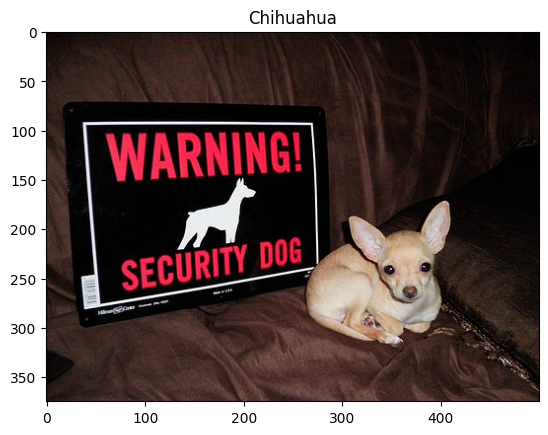

In [13]:

# Plot example from dataset
ex = ds['train'][6200]
plt.imshow(ex['image'])
ex_nr = labels.int2str(ex['label'])
plt.title(breed_dict[int(ex_nr)])


### 1.4 Processing the dataset

In [15]:
"""
To process an image, simply pass it to the image 'processor''s call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model. You get a NumPy array by default, but if you add the return_tensors='pt' argument, you'll get back torch tensors instead.
"""

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs


prepared_ds = ds.with_transform(transform)
print(prepared_ds['train'][0:2])


{'pixel_values': tensor([[[[ 0.8667,  0.8745,  0.8745,  ...,  0.7804,  0.7804,  0.7961],
          [ 0.8431,  0.8745,  0.8824,  ...,  0.7647,  0.7725,  0.7569],
          [ 0.8667,  0.8431,  0.8588,  ...,  0.7647,  0.7412,  0.7333],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.7647,  0.7490,  0.7098,  ...,  0.7412,  0.7412,  0.7569],
          [ 0.7333,  0.7490,  0.7333,  ...,  0.7255,  0.7333,  0.7176],
          [ 0.7569,  0.7176,  0.7333,  ...,  0.7333,  0.7020,  0.6941],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.7176,  0.7020,  0.6627,  ...,  0.7176,  0.7176,  0.7255],
          [ 0

In [ ]:
"""
To process an image, simply pass it to the image 'processor''s call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model. You get a NumPy array by default, but if you add the return_tensors='pt' argument, you'll get back torch tensors instead.
"""

# OLD VERSION BEFORE USING DATASET SOLUTION ABOVE
"""
def transform(dataset_batch, n=None, onehot=False):
     # If n is not specified, load in full dataset
    if n is None:
        n = len(dataset_batch)

    # Initialize dictionary with 'pixel_values' and 'labels'
    inputs = {'pixel_values' : torch.empty((n, 3, 224, 224))}
    if onehot:
        inputs['labels'] = torch.empty((n, 37))
    else:
        inputs['labels'] = torch.empty((n, 1))

    # Load through dataset and send through processor
    for idx in range(n):
        # Load from dataset
        img_i, label_i  = dataset_batch[idx]

        # Process single image
        processed_img = processor(img_i, return_tensors="pt")   # <--- 'processor' returns (inputs) dictionary with key 'pixel_values'

        # Add processed image and labels to dictionary we want to populate
        inputs['pixel_values'][idx] = processed_img['pixel_values'][0]
        if onehot:
            inputs['labels'][idx] = label_i
        else:
            inputs['labels'][idx] = (np.argwhere(label_i==1)+1).item()  # Since label_i is onehot vector, we get single class number (warning: indexing starts at 1)
    return inputs


# NOTE/EXAMPLE: n = 20 only loads in first 20 data entries (for when testing with cpu)
inputs = transform(dataset, n=20, onehot=False)

print(inputs['pixel_values'].shape)   # (20, 3, 224, 224)
print(inputs['labels'].shape)"""


## Training and Evaluation ViT

### Define Collate Function

In [17]:
"""
Batches are coming in as lists of dicts, so you can just unpack + stack those into batch tensors.
Since the collate_fn will return a batch dict, you can **unpack the inputs to the model later
"""

# Define a collate function??? --> seems to put together batches of processed data  (adding dimension in first position??)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])  # stack???
    }


### Define Evaluation metric

In [18]:
"""
The accuracy metric from evaluate can easily be used to compare the predictions with the labels. Below, you can see how to use it within a compute_metrics function that will be used by the Trainer.
"""

metric = load("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


### Define label-to-class translations and ViT thing

In [ ]:
# TODO: FIX AND LOOK INTO NOW THAT WE CHANGED TO DATASET
def onehot_to_number(onehot_label):
    return torch.argmax(onehot_label).item() + 1   # NOTE: Class numbers starts index at 1

def number_to_name(num):
    return breed_dict[num]

"""

def plot_data_entry(dataset, ni=2600):
    img_i, label_i = dataset[ni]
    label_i_nr = onehot_to_number(label_i)
    plt.imshow(img_i.permute(1, 2, 0))
    plt.title(f"label={label_i_nr}={breed_dict[label_i_nr]}")
    plt.axis('off')
    plt.show()


# EXAMPLE USE OF CODE ABOVE
ni = 600
num = onehot_to_number(dataset[ni][1])   # gets single number for breed
breedname = breed_dict[num]              # gets word version of breed
print(f"{num} = {breedname}")
plot_data_entry(dataset, ni)


#Getting is list of all the breed names for the model in next cell.

n = 50   #  n = len(dataset) # <--- instead of full dataset, do 50 for now
labels = [breed_dict[onehot_to_number(dataset[ni][1])] for ni in range(n)]

#print(labels[:10])
"""

# NOTE: Remaining below has not been run or tested, only copied in from tutorial

## Some TODO's:
* (DONE) Convert and use Dataset class according to tutorial for ViT

* (DONE) Create 'prepared_ds' equivalent for our data and solution

* (kind of DONE) Look into other models which we can load in to try (currently using from tutorial: 'google/vit-base-patch16-224-in21k')

* (DONE) Split data into training, validation, testing

* IMPORTANT: Change things to utilize torch and device='cuda', to ensure we USE the GPU and not the CPU
* Try running everything on the GPU:
    * note: Use all data


### Initialize Pretrained model (ViTForImageClassification)

In [21]:
"""
Let's load the pretrained model. We'll add num_labels on init so the model creates a classification head with the right number of units. We'll also include the id2label and label2id mappings to have human-readable labels in the Hub widget (if you choose to push_to_hub).
"""

labels = ds["train"].features["label"].names

#idx2label = {str(idx): label for idx, label in enumerate(labels)}
#label2idx = {label: str(idx) for idx, label in enumerate(labels)}
# Get random int to test
#print(f"Breed: {idx2label[ds['train'][4000]['label']]}")
#plt.imshow(ds['train'][4000]['image'])

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Set up training arguments

In [ ]:
"""
Almost ready to train! The last thing needed before that is to set up the training configuration by defining TrainingArguments.

Most of these are pretty self-explanatory, but one that is quite important here is remove_unused_columns=False. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set remove_unused_columns=False.
"""

training_args = TrainingArguments(
  output_dir="/vit-base-oxford-pet",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='none', #'tensorboard',
  load_best_model_at_end=True,
)



In [ ]:
"""
Now, all instances can be passed to Trainer and we are ready to start training!
"""

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"], # TODO: Create prepared_ds (see tutorial for context and figure out appropriate solution) https://huggingface.co/blog/fine-tune-vit
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

### TRAIN ViT

In [ ]:

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


### EVALUATE ViT

In [ ]:

metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)
